# Import packages

In [2]:
import scvi_v2
import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import seaborn as sns

/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# BT112

In [3]:
lfc_df = pd.read_csv('bt112_DRC_lfc_01122024.csv', index_col=0)
pval_df = pd.read_csv('BT112_DRC_GLM_DEG_qvalue_matrix_20240125.csv', index_col=0)

outlier_gene = set(lfc_df.index).difference(set(pval_df.index)).pop()
lfc_df = lfc_df[lfc_df.index != outlier_gene]

df = lfc_df.join(pval_df)
df.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,...,BT112_21,BT112_22,BT112_23,BT112_3,BT112_4,BT112_5,BT112_6,BT112_7,BT112_8,BT112_9
RRP7BP,-0.331918,-0.268208,-0.164830,-0.212687,-0.189588,-0.102799,-0.232650,-0.177985,-0.036181,-0.084422,...,0.998826,0.994342,0.180254,0.677796,0.403160,0.279722,0.641530,0.937602,0.695694,0.911089
TULP4,-0.228447,-0.430173,-0.093579,-0.133452,-0.166163,-0.114159,-0.238929,-0.094378,-0.078107,-0.194185,...,0.976253,0.586061,0.080521,0.499383,0.806889,0.794174,0.448738,0.864631,0.998826,0.644560
MAP3K14,0.425852,-0.154187,-0.021759,0.075440,0.013685,-0.042315,0.049413,0.064243,-0.032983,0.123364,...,0.998826,0.384627,0.157766,0.311514,0.574636,0.350004,0.684245,0.807283,0.579220,0.998826
ZNFX1,-0.200047,0.124471,-0.023921,0.026045,0.044150,0.076410,0.023691,0.035925,0.047769,-0.123172,...,0.461768,0.013708,0.993451,0.456140,0.879779,0.523158,0.144017,0.727957,0.708500,0.085589
TRIM25,-0.059534,-0.184253,0.038570,0.010690,-0.079139,-0.082420,-0.047613,-0.005714,-0.080240,0.043089,...,0.549700,0.416746,0.000153,0.000374,0.551286,0.180218,0.888171,0.112602,0.035200,0.490713


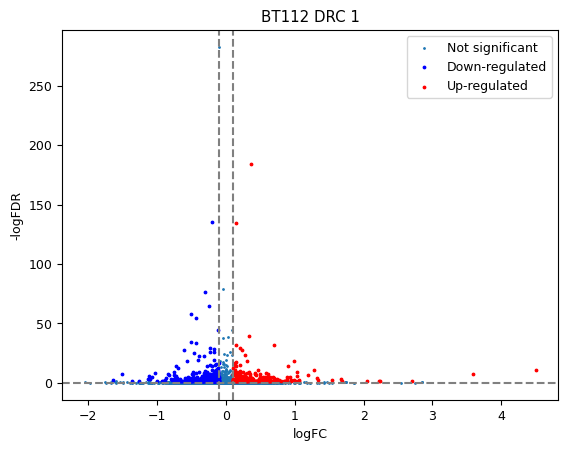

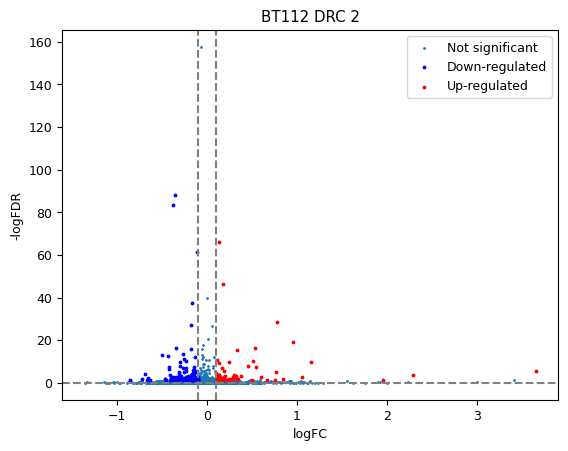

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/2794397460.py:9: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT112_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/2794397460.py:18: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=down['cluster_%d'%drc],y=down['BT112_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")


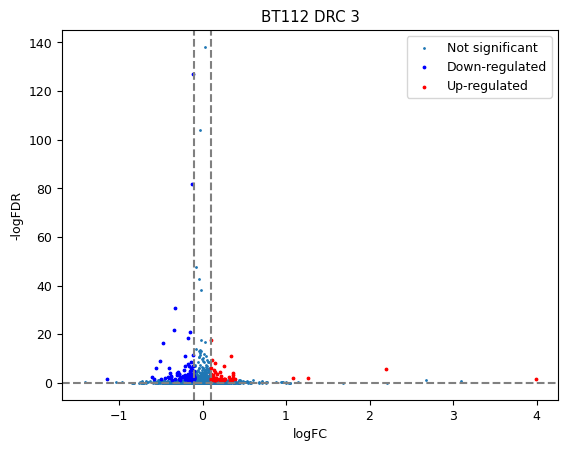

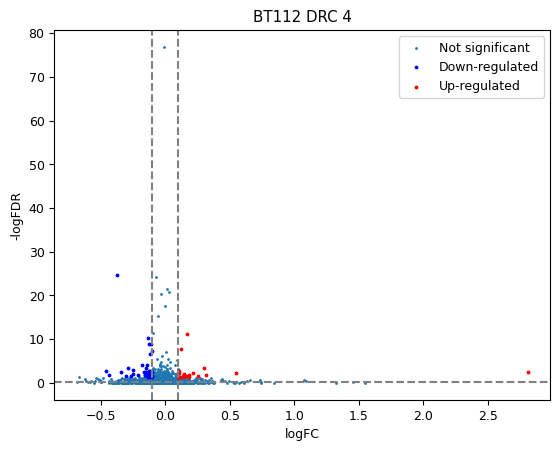

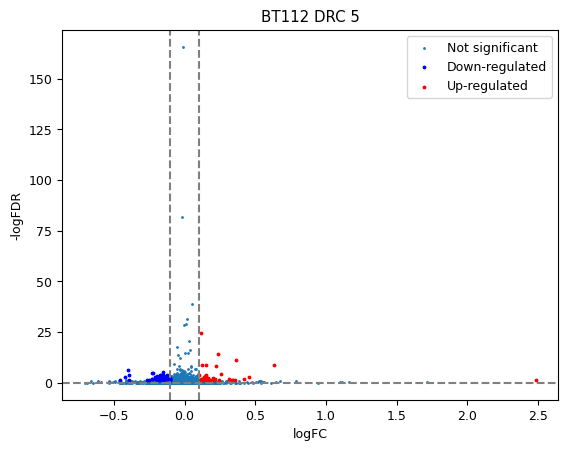

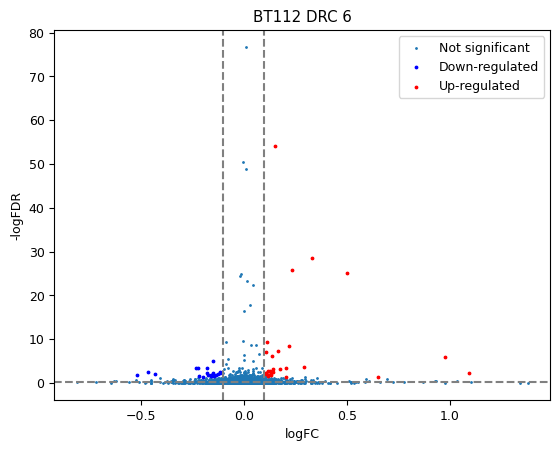

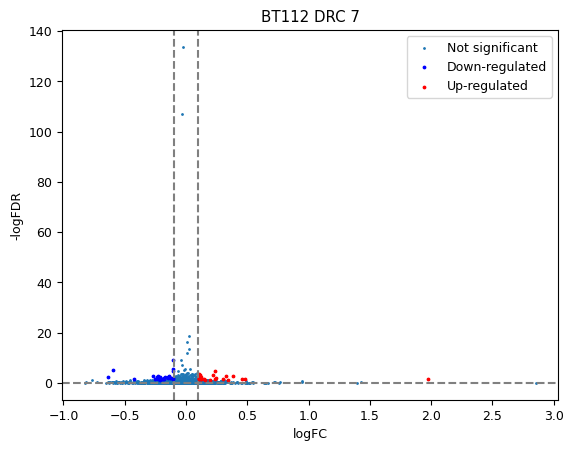

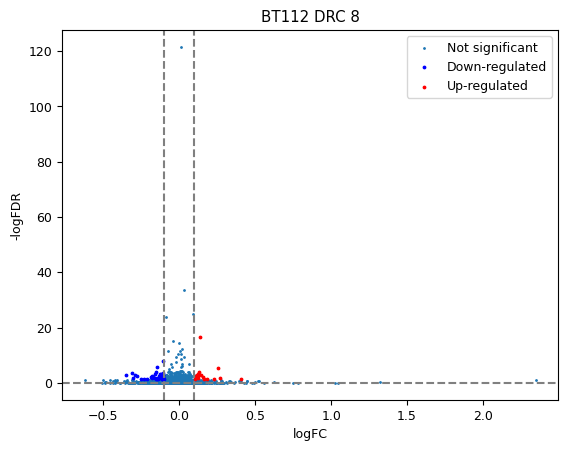

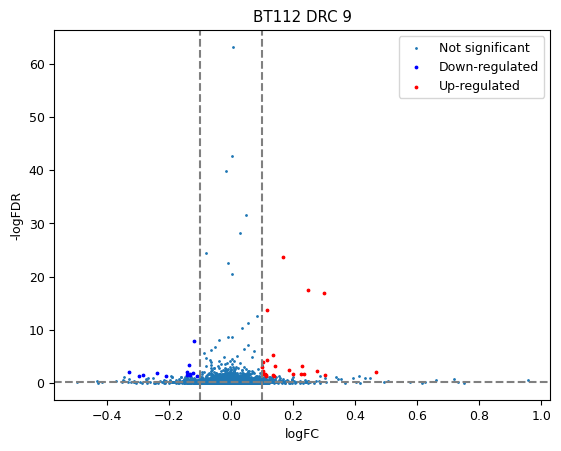

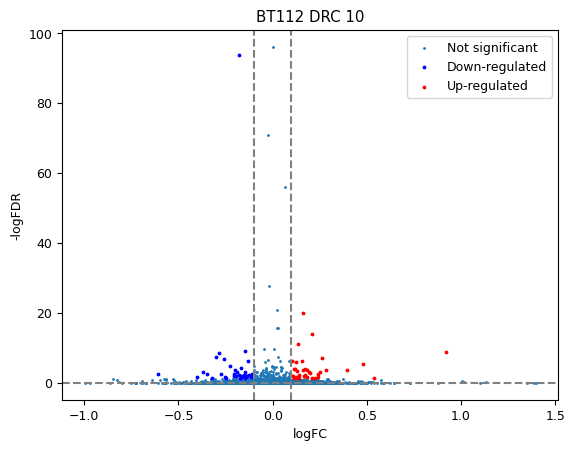

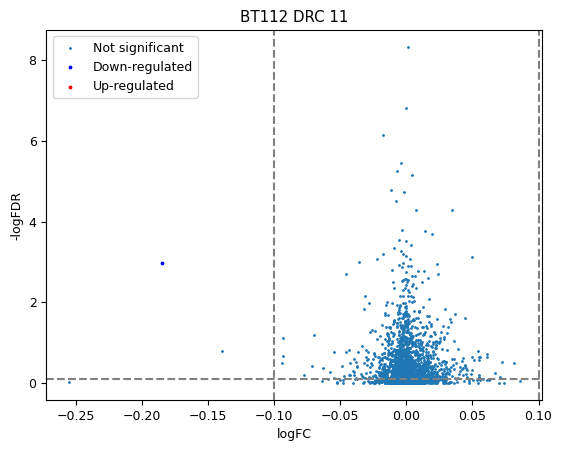

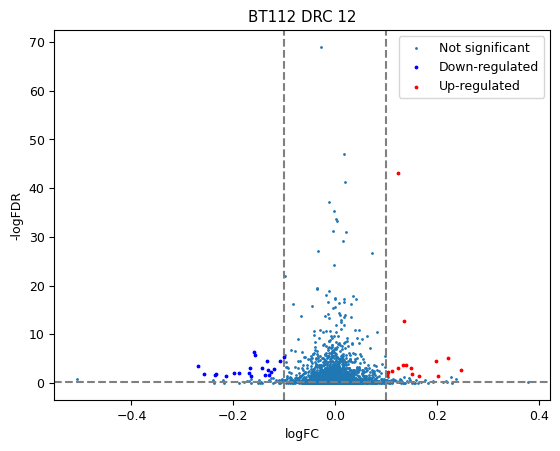

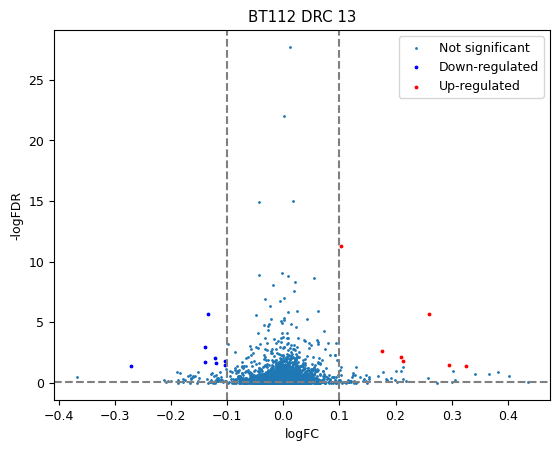

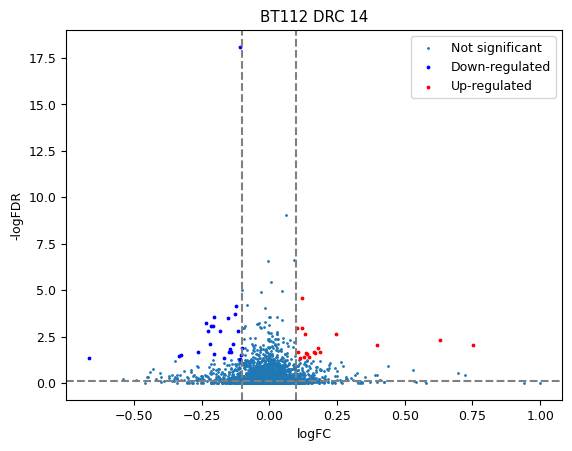

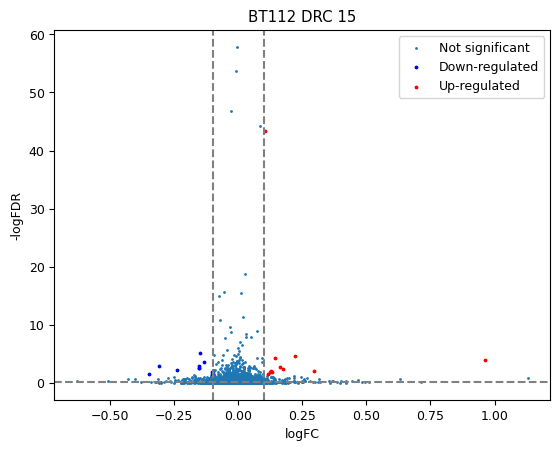

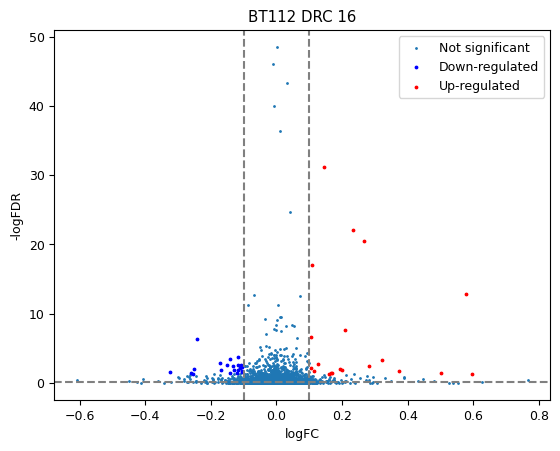

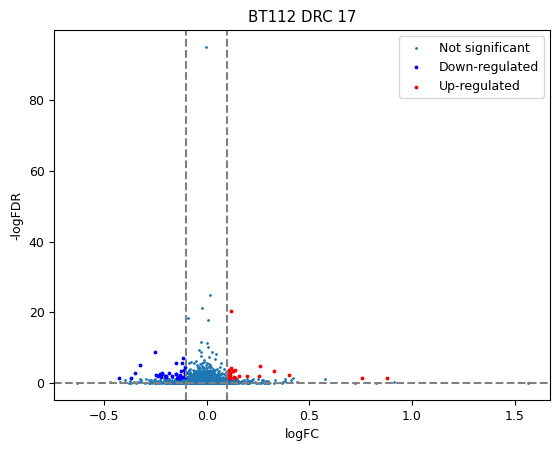

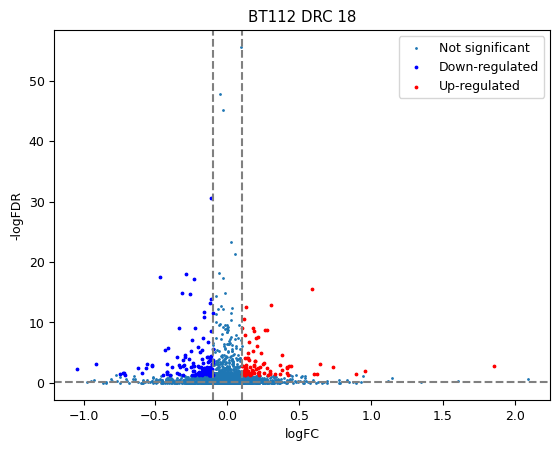

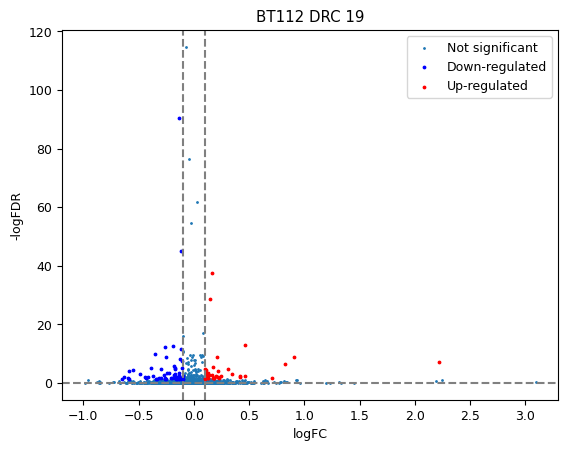

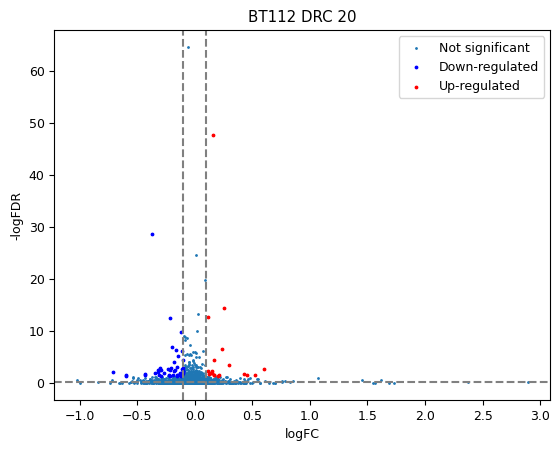

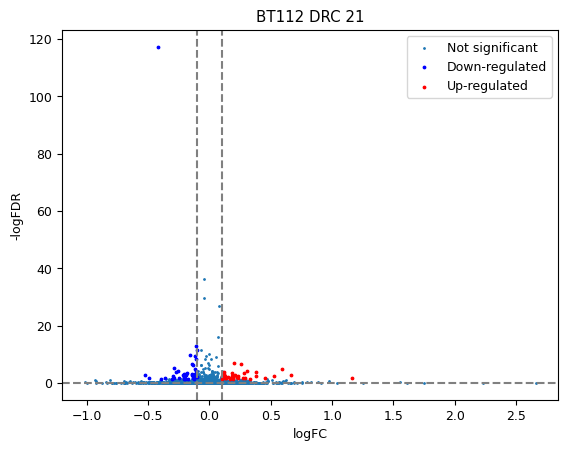

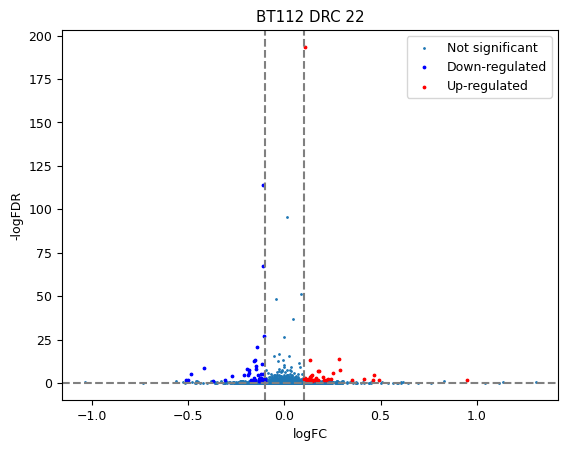

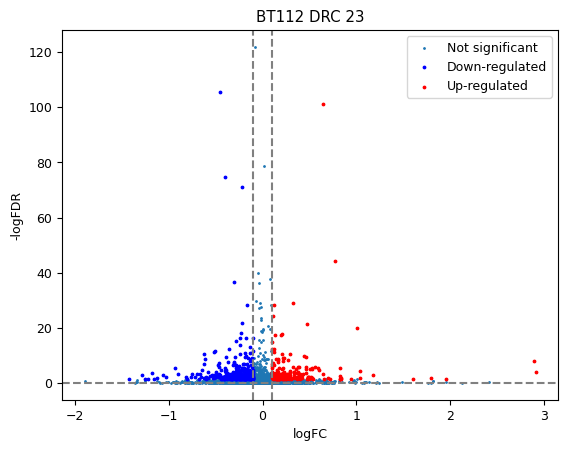

In [5]:
num_degs = []
de_dfs = {}

lfc_th = 0.1
pval_th = 0.05

for drc in range(1,lfc_df.shape[1]+1):

    axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT112_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

    # highlight down- or up- regulated genes
    down = df[(df['cluster_%d'%drc]<=-lfc_th)&(df['BT112_%d'%drc]<=pval_th)]
    up = df[(df['cluster_%d'%drc]>=lfc_th)&(df['BT112_%d'%drc]<=pval_th)]
    
    de_dfs[drc] = pd.concat([up,down]).iloc[:,0:lfc_df.shape[1]]
    # de_dfs[drc] = up.iloc[:,0:lfc_df.shape[1]]

    axs = plt.scatter(x=down['cluster_%d'%drc],y=down['BT112_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    axs = plt.scatter(x=up['cluster_%d'%drc],y=up['BT112_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-lfc_th,color="grey",linestyle="--")
    plt.axvline(lfc_th,color="grey",linestyle="--")
    plt.axhline(lfc_th,color="grey",linestyle="--")
    plt.legend()
    plt.title('BT112 DRC %d'%drc)
    
    plt.savefig(
        "BT112_DRC_%d_volcano.png"%drc, 
        dpi = 900
    ) 
    
    plt.show()

    num_degs.append(down.shape[0] + up.shape[0])

In [6]:
print('Avg # DEGS: ' + str(round(np.mean(num_degs))))
pd.DataFrame(
    num_degs, 
    index=['BT112_%d'%i for i in range(1,lfc_df.shape[1]+1)], 
    columns=['Num_DEGs']
)

Avg # DEGS: 108


,Num_DEGs
BT112_1,509
BT112_2,187
BT112_3,155
BT112_4,59
BT112_5,88
BT112_6,48
BT112_7,52
BT112_8,56
BT112_9,37
BT112_10,72


In [165]:
# write gene signatures to csv

for drc in range(1,lfc_df.shape[1]+1): 
    pd.DataFrame(de_dfs[drc].index.tolist()).to_csv('bt112_DRC%d_signature_01252024.csv'%drc)


In [7]:
# Create a unionized set of DE genes 
de_genes = set()

for drc in range(1,lfc_df.shape[1]+1):
    de_genes = de_genes.union(set(de_dfs[drc].index.tolist()))

pd.DataFrame(de_genes)

# Save the DE genes 
pd.DataFrame(de_genes).to_csv('BT112_de_genes_01252024.csv')

,0
0,RCAN1
1,ARMCX4
2,CACNA2D1
3,SH3BP5
4,MAP1S
...,...
1170,BICD1
1171,CDK14
1172,MITF
1173,SLC7A11


# BT228

In [8]:
lfc_df = pd.read_csv('bt228_DRC_lfc_01122024.csv', index_col=0)
pval_df = pd.read_csv('BT228_DRC_GLM_DEG_qvalue_matrix_20240125.csv', index_col=0)

outlier_gene = set(lfc_df.index).difference(set(pval_df.index)).pop()
lfc_df = lfc_df[lfc_df.index != outlier_gene]

df = lfc_df.join(pval_df)
df.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,...,BT228_19,BT228_2,BT228_20,BT228_3,BT228_4,BT228_5,BT228_6,BT228_7,BT228_8,BT228_9
CMIP,0.302694,0.006777,0.016640,0.005719,-0.006326,0.012137,-0.017119,-0.027718,-0.011237,0.005000,...,0.008320,0.471048,0.533044,0.730103,0.057521,0.538096,0.563332,0.864757,0.805364,0.156393
PLD1,0.321277,0.023092,0.032358,0.032881,-0.004548,-0.007921,-0.019842,0.008365,0.017951,0.030812,...,0.998826,0.108722,0.998826,0.989605,0.000258,0.674716,0.782898,0.570357,0.996152,0.284407
SPATA5,0.427089,-0.025549,-0.035303,-0.034937,-0.006261,0.009816,0.006823,-0.049101,-0.044576,-0.043841,...,0.257058,0.661935,0.420367,0.594195,0.149349,0.761530,0.877728,0.398283,0.308358,0.115645
TP53BP2,-0.002471,-0.004310,0.009393,-0.008574,-0.003512,0.041397,-0.003571,-0.008020,-0.012365,0.000924,...,0.001890,0.292325,0.708578,0.232065,0.302286,0.971095,0.309448,0.646294,0.375933,0.872273
INF2,0.253474,0.005061,0.011729,0.006671,-0.004772,0.003334,-0.009830,-0.002144,0.003625,0.007379,...,0.906012,0.670421,0.395382,0.370377,0.922331,0.212307,0.429026,0.029741,0.805348,0.443461


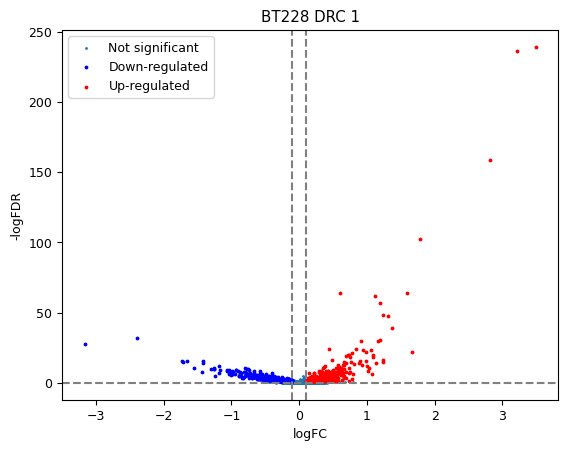

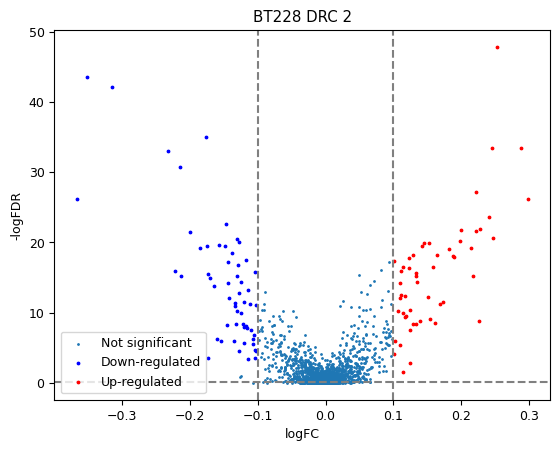

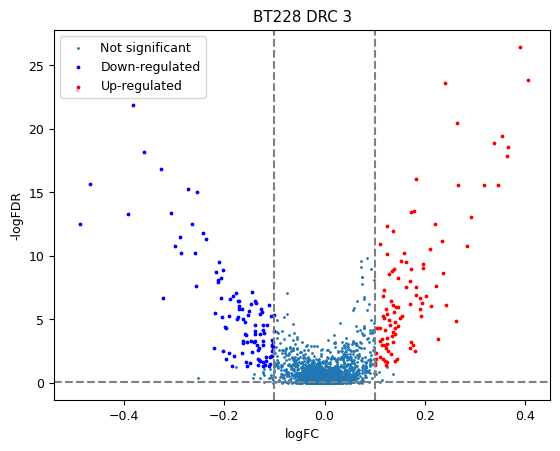

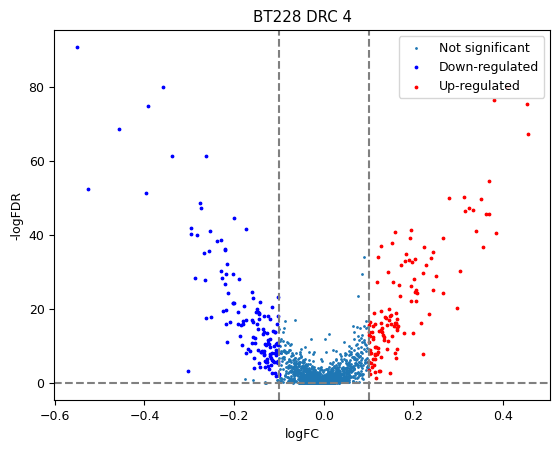

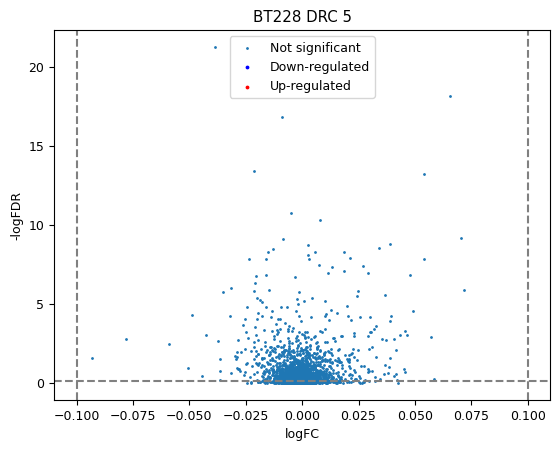

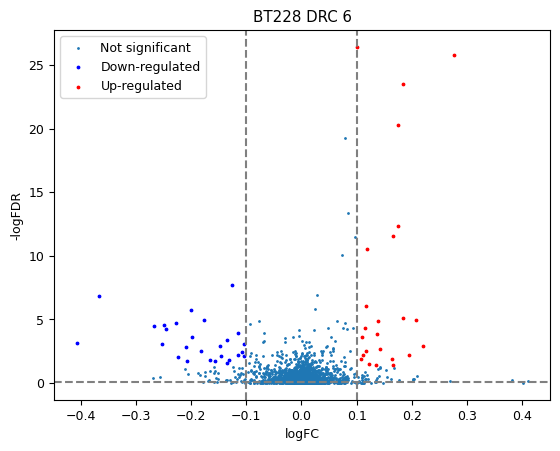

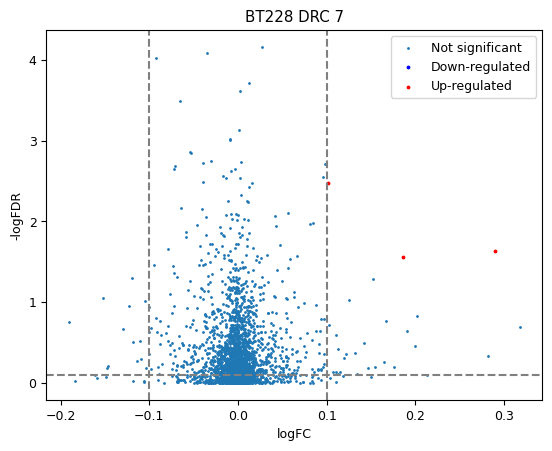

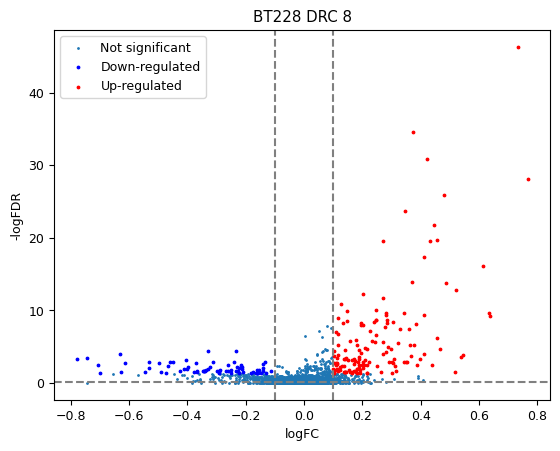

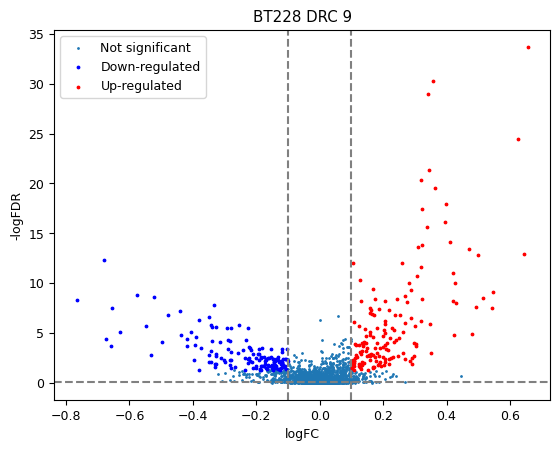

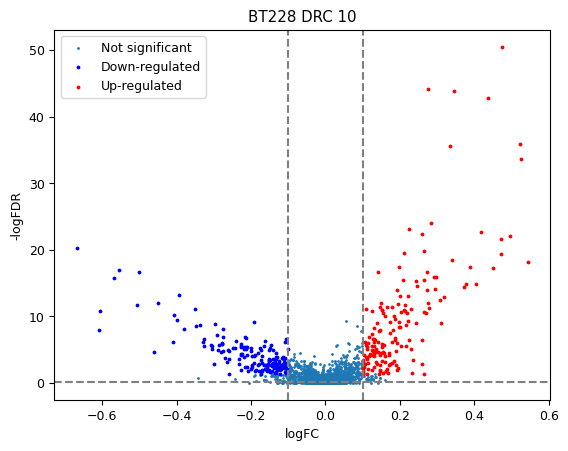

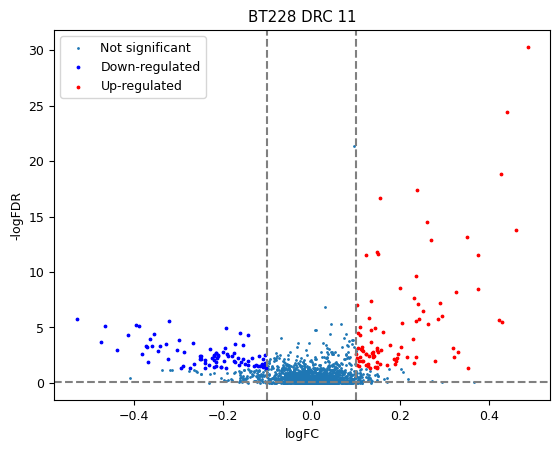

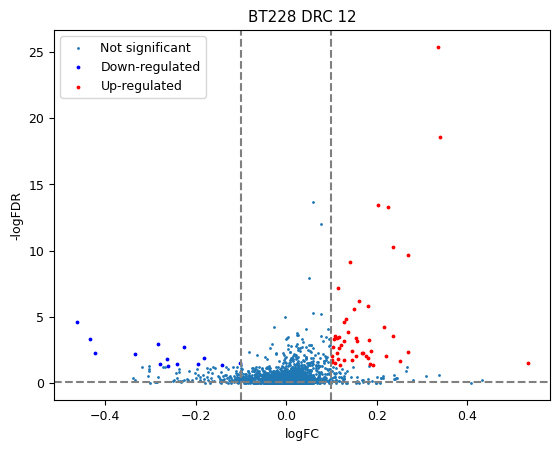

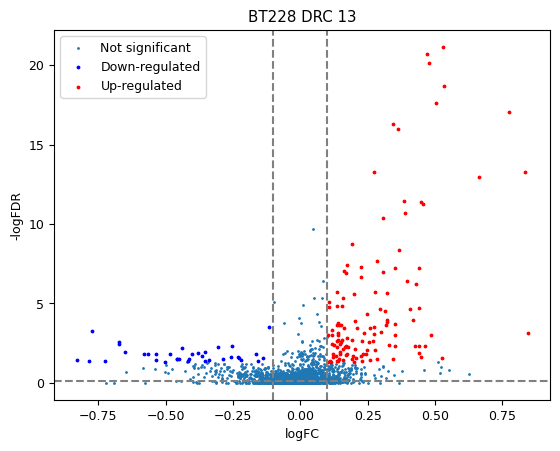

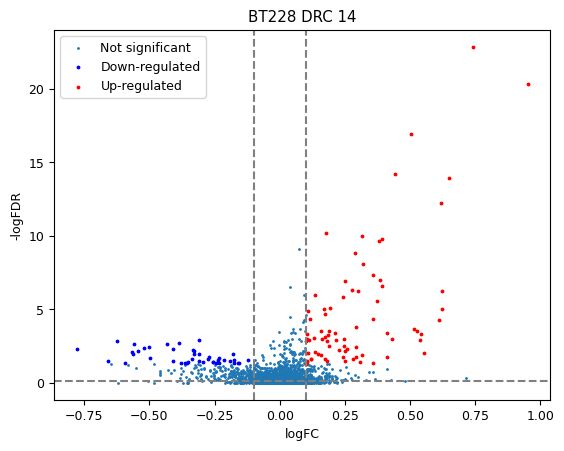

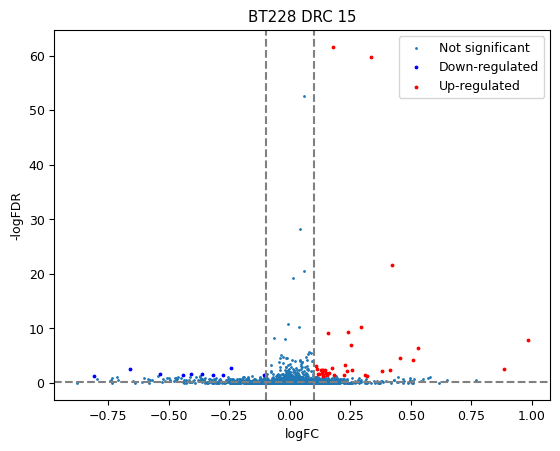

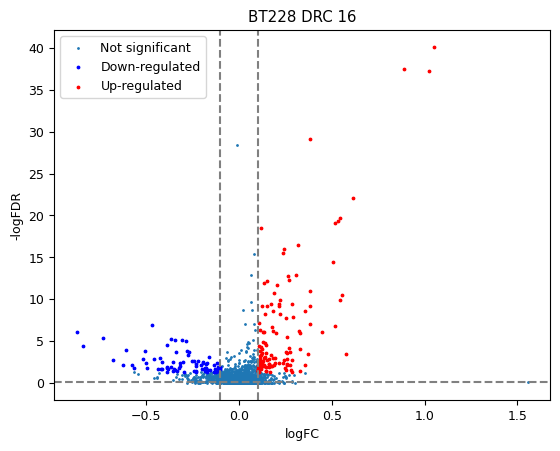

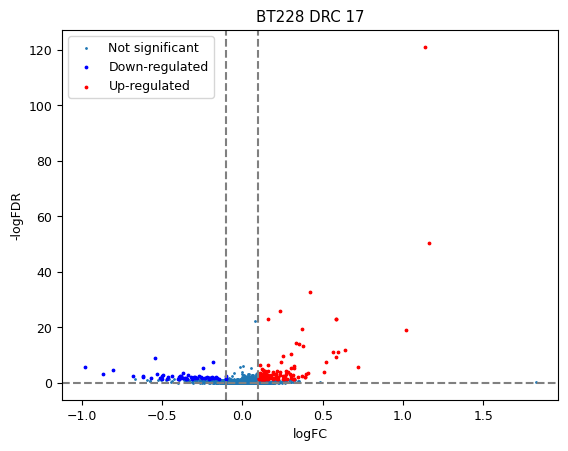

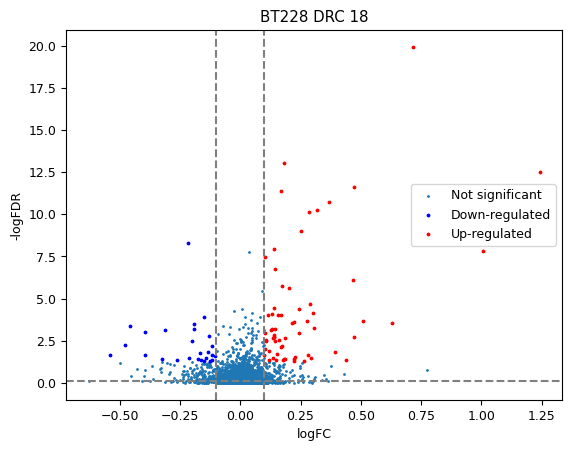

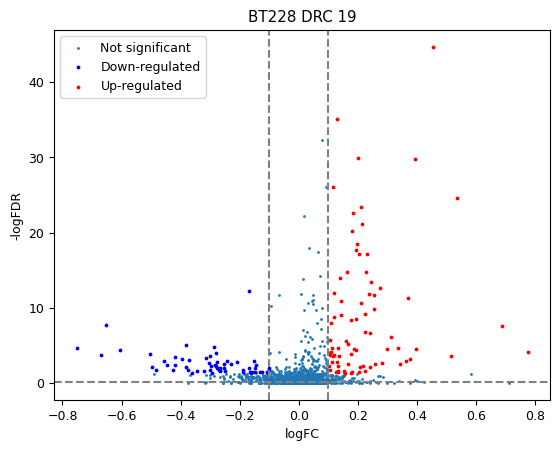

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1393426527.py:9: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT228_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1393426527.py:22: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=up['cluster_%d'%drc],y=up['BT228_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")


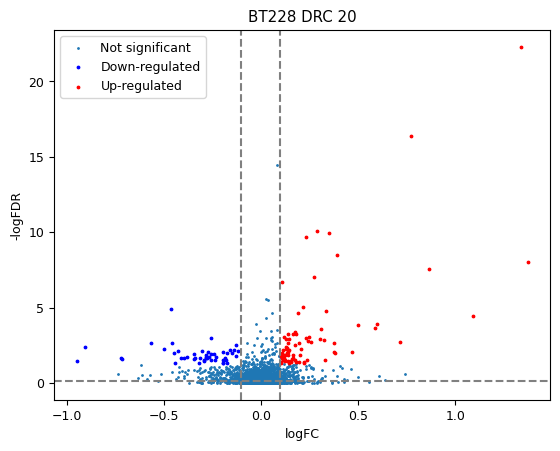

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})

num_degs = []
de_dfs = {}

for drc in range(1,lfc_df.shape[1]+1):

    axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT228_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

    lfc_th = 0.1
    pval_th = 0.05

    # highlight down- or up- regulated genes
    down = df[(df['cluster_%d'%drc]<=-lfc_th)&(df['BT228_%d'%drc]<=pval_th)]
    up = df[(df['cluster_%d'%drc]>=lfc_th)&(df['BT228_%d'%drc]<=pval_th)]
    
    de_dfs[drc] = pd.concat([up,down]).iloc[:,0:lfc_df.shape[1]]
    # de_dfs[drc] = up.iloc[:,0:lfc_df.shape[1]]

    axs = plt.scatter(x=down['cluster_%d'%drc],y=down['BT228_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    axs = plt.scatter(x=up['cluster_%d'%drc],y=up['BT228_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-lfc_th,color="grey",linestyle="--")
    plt.axvline(lfc_th,color="grey",linestyle="--")
    plt.axhline(lfc_th,color="grey",linestyle="--")
    plt.legend()
    plt.title('BT228 DRC %d'%drc)
    
    plt.savefig(
        "BT228_DRC_%d_volcano.png"%drc, 
        dpi = 900
    ) 
    
    plt.show()

    num_degs.append(down.shape[0] + up.shape[0])

In [11]:
print('Avg # DEGS: ' + str(round(np.mean(num_degs))))
pd.DataFrame(
    num_degs, 
    index=['BT228_%d'%i for i in range(1,lfc_df.shape[1]+1)], 
    columns=['Num_DEGs']
)

Avg # DEGS: 178


,Num_DEGs
BT228_1,783
BT228_2,111
BT228_3,207
BT228_4,260
BT228_5,0
BT228_6,51
BT228_7,3
BT228_8,214
BT228_9,300
BT228_10,328


In [171]:
# write gene signatures to csv 

for drc in range(1,lfc_df.shape[1]+1): 
    pd.DataFrame(de_dfs[drc].index.tolist()).to_csv('bt228_DRC%d_signature_01252024.csv'%drc)


In [10]:
# Create a unionized set of DE genes 
de_genes = set()

for drc in range(1,lfc_df.shape[1]+1):
    de_genes = de_genes.union(set(de_dfs[drc].index.tolist()))

pd.DataFrame(de_genes)

# Save the DE genes 
pd.DataFrame(de_genes).to_csv('BT228_de_genes_01252024.csv')

,0
0,ARFGEF3
1,RCAN1
2,CACNA2D1
3,ALOX12-AS1
4,GPSM2
...,...
1117,BICD1
1118,CDK14
1119,PEX1
1120,SLC7A11


# BT333

In [13]:
lfc_df = pd.read_csv('bt333_DRC_lfc_01122024.csv', index_col=0)
pval_df = pd.read_csv('BT333_DRC_GLM_DEG_qvalue_matrix_20240125.csv', index_col=0)

outlier_gene = set(lfc_df.index).difference(set(pval_df.index)).pop()
lfc_df = lfc_df[lfc_df.index != outlier_gene]

df = lfc_df.join(pval_df)
df.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,...,BT333_23,BT333_24,BT333_25,BT333_3,BT333_4,BT333_5,BT333_6,BT333_7,BT333_8,BT333_9
SOX2,-0.143322,-0.168565,0.043121,0.026123,0.058398,-0.034926,-0.011140,0.029641,-0.013452,-0.002229,...,0.793520,0.180102,0.943701,0.182676,0.054169,0.718557,0.996283,0.988883,0.882398,0.311319
PPP2R5A,0.120411,0.131274,-0.044067,-0.078970,-0.054548,0.047221,0.006728,-0.021274,0.019096,-0.004331,...,0.588523,0.097975,0.998780,0.937908,0.565674,0.546977,0.338018,0.602525,0.737606,0.812092
ARPC4,0.054008,0.098901,-0.004688,-0.023396,-0.066385,0.059876,0.017999,-0.040024,0.002847,0.021397,...,0.403619,0.288965,0.998468,0.352577,0.129521,0.971644,0.694574,0.660797,0.757331,0.901761
LMNB2,-0.013012,-0.013943,0.005533,0.001088,0.000953,0.002988,-0.001593,0.000212,-0.001531,-0.000330,...,0.044137,0.035553,0.814712,0.000375,0.003501,0.584523,0.862696,0.001035,0.377708,0.767885
ZDHHC17,0.225862,0.219824,0.002335,0.013810,0.049284,-0.002657,-0.005264,0.022598,-0.006791,-0.003433,...,0.952948,0.000402,0.470741,0.534758,0.020870,0.172520,0.125315,0.785939,0.554854,0.252458


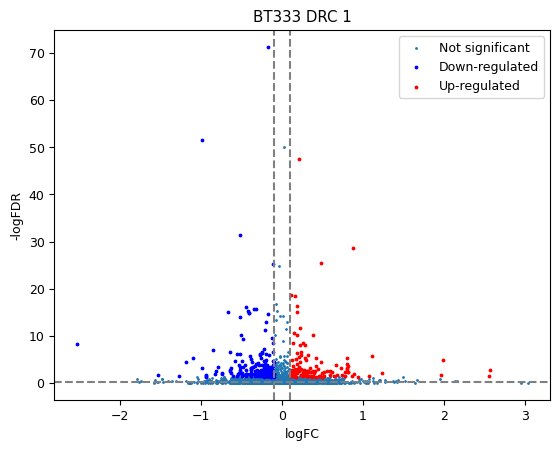

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1614175600.py:6: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1614175600.py:19: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=up['cluster_%d'%drc],y=up['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")


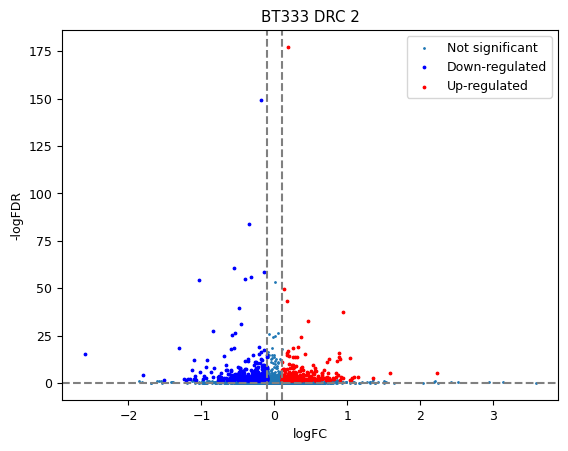

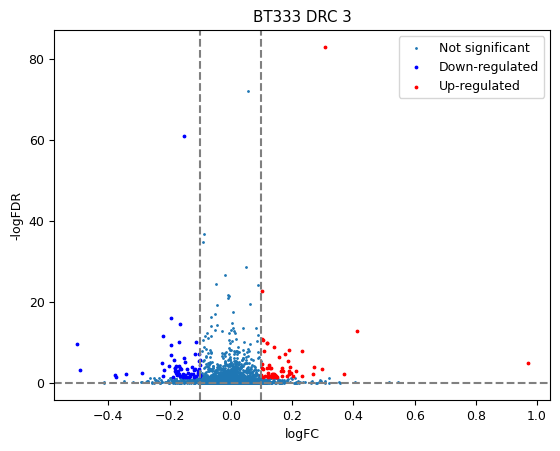

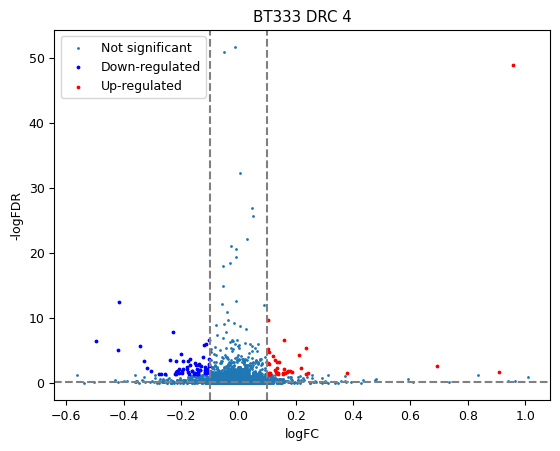

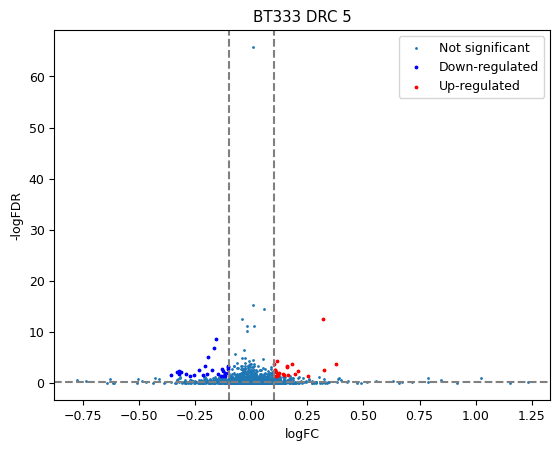

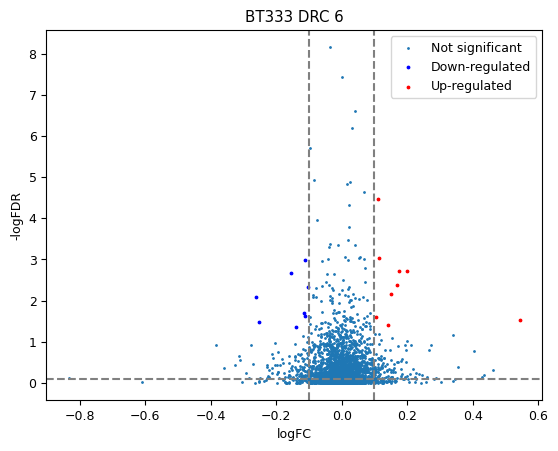

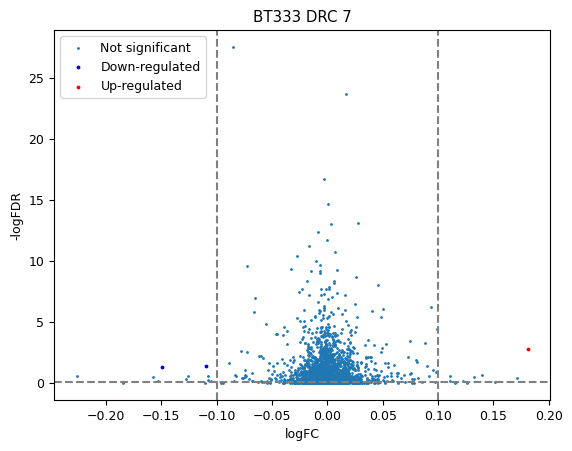

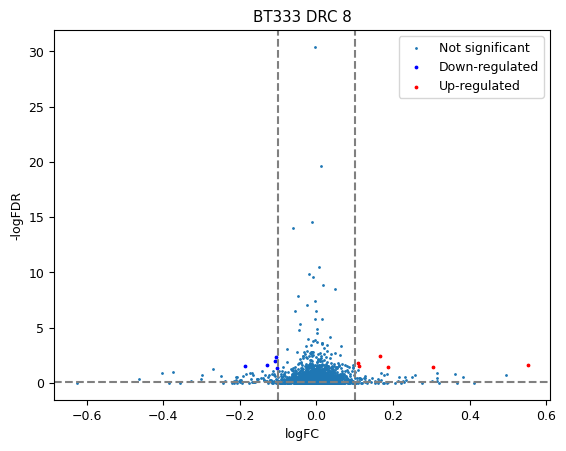

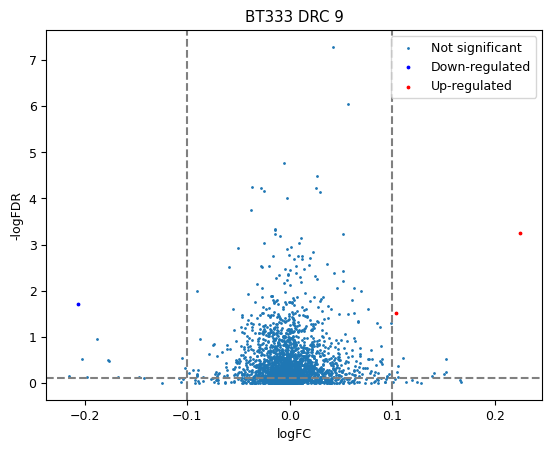

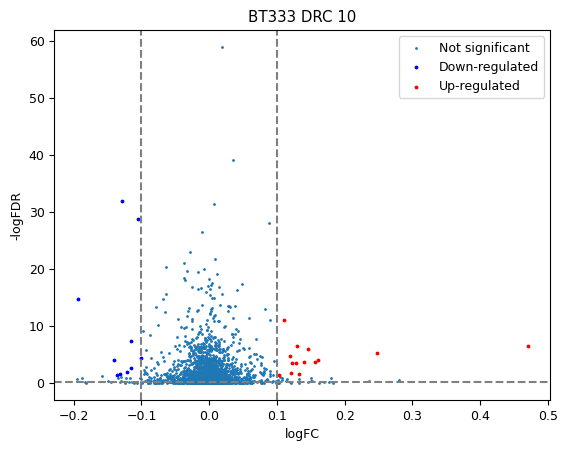

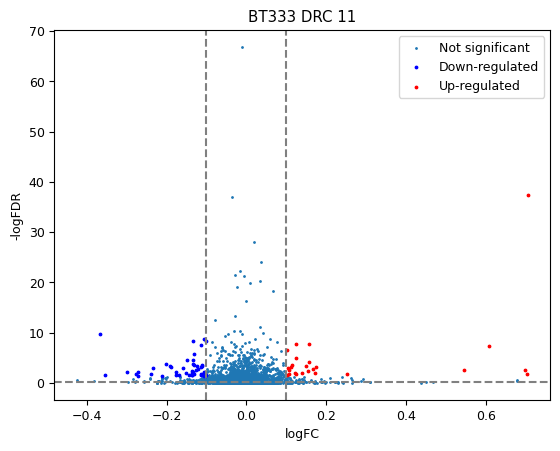

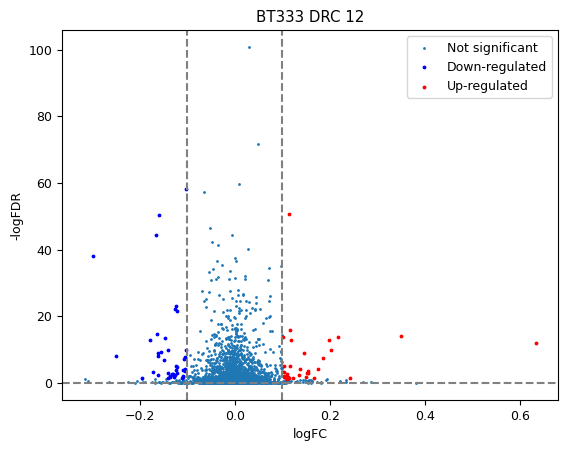

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1614175600.py:6: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")


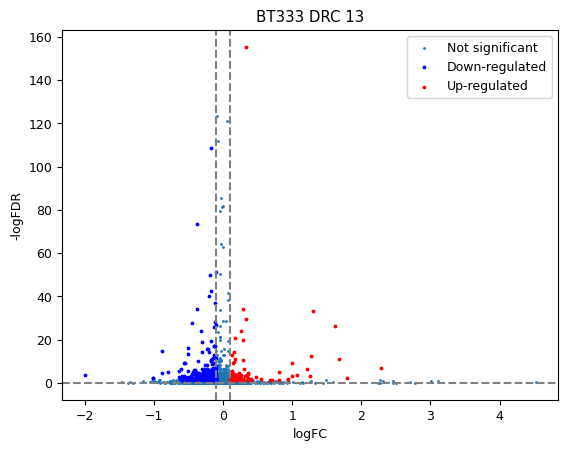

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_41811/1614175600.py:6: RuntimeWarning: divide by zero encountered in log10
  axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")


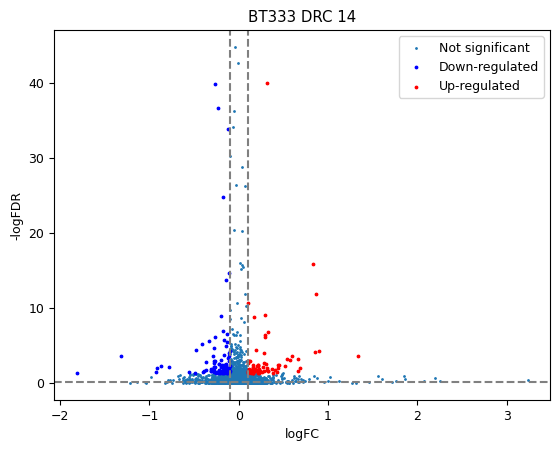

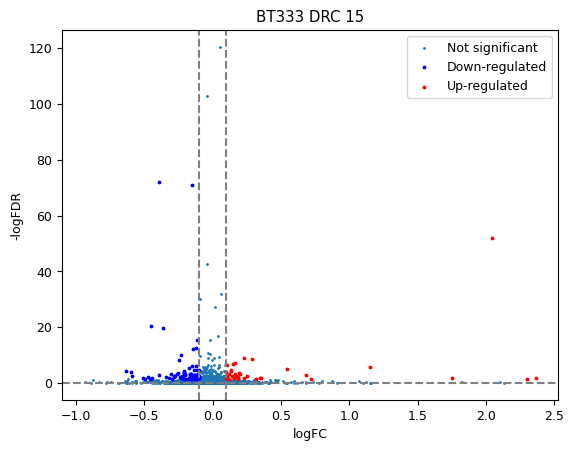

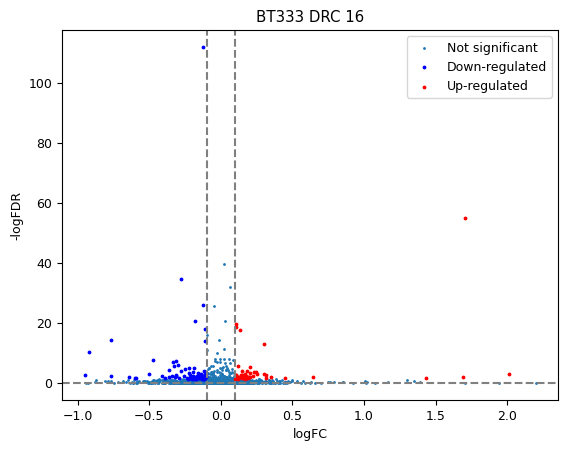

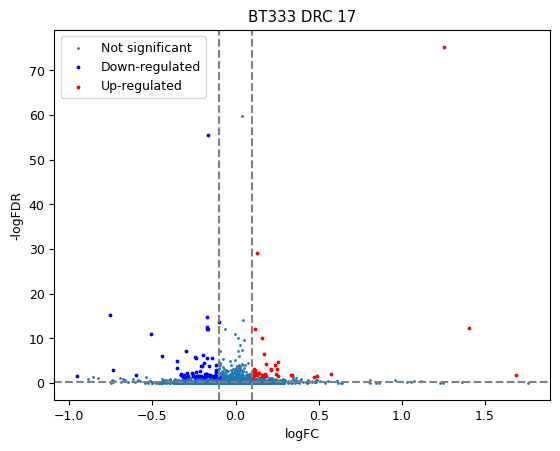

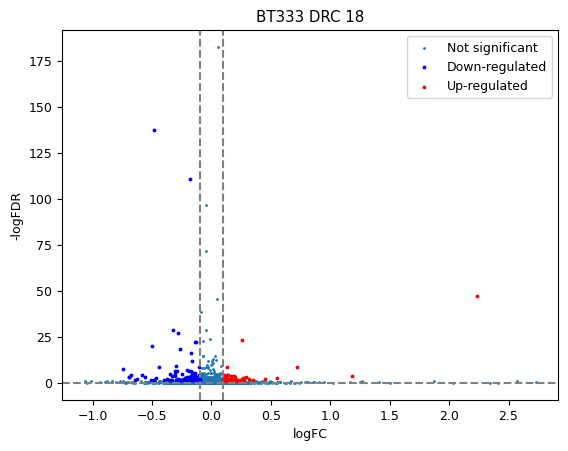

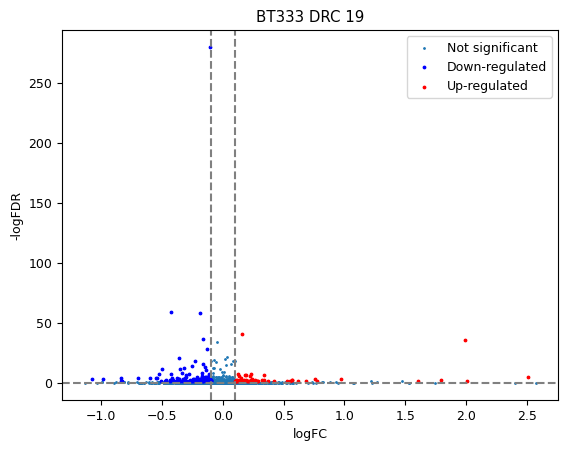

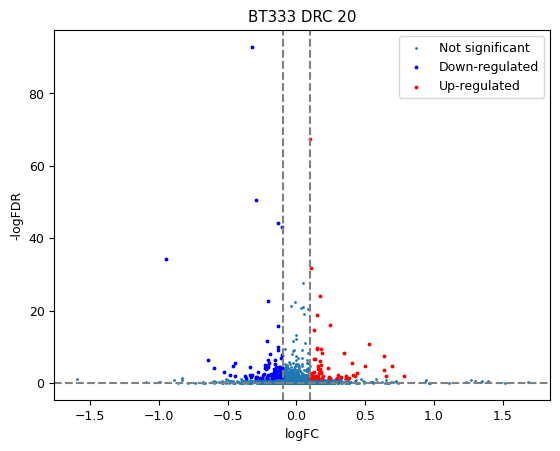

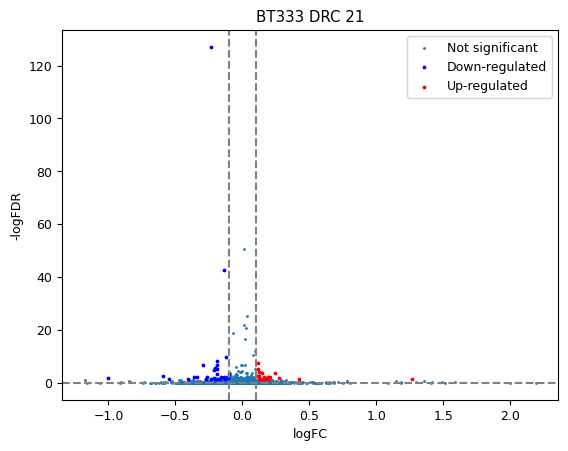

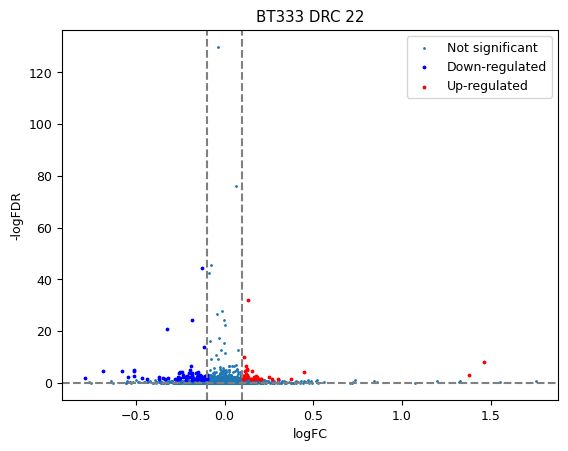

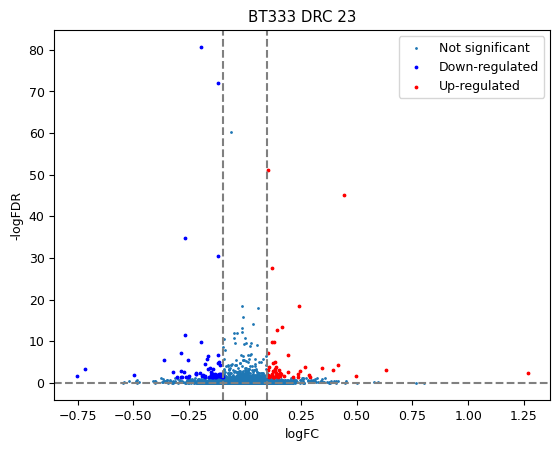

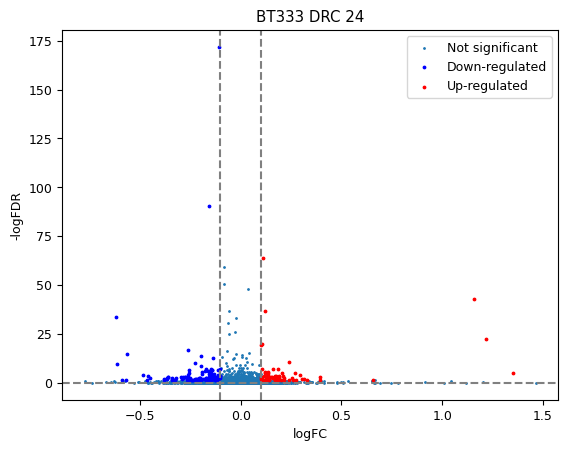

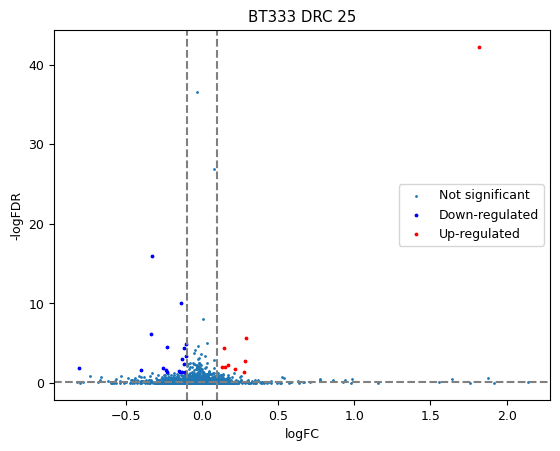

In [14]:
num_degs = []
de_dfs = {}

for drc in range(1,lfc_df.shape[1]+1):

    axs = plt.scatter(x=df['cluster_%d'%drc],y=df['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

    lfc_th = 0.1
    pval_th = 0.05

    # highlight down- or up- regulated genes
    down = df[(df['cluster_%d'%drc]<=-lfc_th)&(df['BT333_%d'%drc]<=pval_th)]
    up = df[(df['cluster_%d'%drc]>=lfc_th)&(df['BT333_%d'%drc]<=pval_th)]
    
    de_dfs[drc] = pd.concat([up,down]).iloc[:,0:lfc_df.shape[1]]
    # de_dfs[drc] = up.iloc[:,0:lfc_df.shape[1]]

    axs = plt.scatter(x=down['cluster_%d'%drc],y=down['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    axs = plt.scatter(x=up['cluster_%d'%drc],y=up['BT333_%d'%drc].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-lfc_th,color="grey",linestyle="--")
    plt.axvline(lfc_th,color="grey",linestyle="--")
    plt.axhline(lfc_th,color="grey",linestyle="--")
    plt.legend()
    plt.title('BT333 DRC %d'%drc)
    
    plt.savefig(
        "BT333_DRC_%d_volcano.png"%drc, 
        dpi = 900
    ) 
    
    plt.show()

    num_degs.append(down.shape[0] + up.shape[0])

In [15]:
print('Avg # DEGS: ' + str(round(np.mean(num_degs))))
pd.DataFrame(
    num_degs, 
    index=['BT333_%d'%i for i in range(1,lfc_df.shape[1]+1)], 
    columns=['Num_DEGs']
)

Avg # DEGS: 132


,Num_DEGs
BT333_1,322
BT333_2,608
BT333_3,120
BT333_4,101
BT333_5,50
BT333_6,17
BT333_7,3
BT333_8,11
BT333_9,3
BT333_10,24


In [176]:
# write gene signatures to csv 

for drc in range(1,lfc_df.shape[1]+1): 
    pd.DataFrame(de_dfs[drc].index.tolist()).to_csv('bt333_DRC%d_signature_01252024.csv'%drc)


In [16]:
# Create a unionized set of DE genes 
de_genes = set()

for drc in range(1,lfc_df.shape[1]+1):
    de_genes = de_genes.union(set(de_dfs[drc].index.tolist()))

pd.DataFrame(de_genes)

# Save the DE genes 
pd.DataFrame(de_genes).to_csv('BT333_de_genes_01252024.csv')

,0
0,PLEKHJ1
1,FRMD6
2,CTNNAL1
3,CRCP
4,DPM2
...,...
1275,DMWD
1276,CDK14
1277,PEX1
1278,SLC7A11
